In [1]:
import fetching
import requests
import datetime
import pandas as pd
import numpy as np 
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
from collections import Counter
import copy
from operator import itemgetter
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

,close,high,low,open,time,volumefrom,volumeto,timestamp
Date,,,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,1279324800,20.00,0.9902,2010-07-17 02:00:00
2010-07-18,0.08584,0.08585,0.05941,0.04951,1279411200,75.01,5.0900,2010-07-18 02:00:00
2010-07-19,0.08080,0.09307,0.07723,0.08584,1279497600,574.00,49.6600,2010-07-19 02:00:00
2010-07-20,0.07474,0.08181,0.07426,0.08080,1279584000,262.00,20.5900,2010-07-20 02:00:00
2010-07-21,0.07921,0.07921,0.06634,0.07474,1279670400,575.00,42.2600,2010-07-21 02:00:00


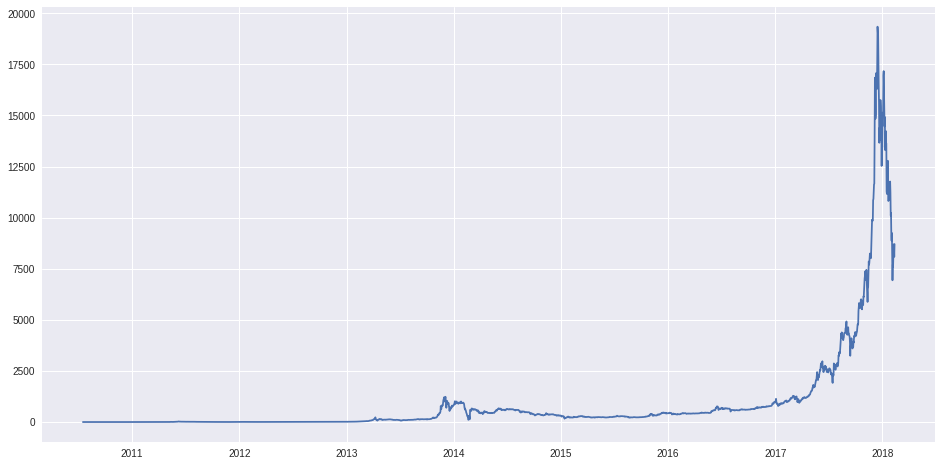

In [2]:
df = fetching.fetch.price_history('BTC', 'USD', True)
sns.set(rc={'figure.figsize':(16,8)})
plt.plot(df.timestamp, df.close)

df['Date'] = df['timestamp'].dt.strftime('%Y-%m-%d')
df = df.set_index('Date')
df.head(5)

In [3]:
media = fetching.fetch.media_coverage()
media.head()

,Value
Date,
2017-02-18,0.0194
2017-02-19,0.0199
2017-02-20,0.0291
2017-02-21,0.0332
2017-02-22,0.0379


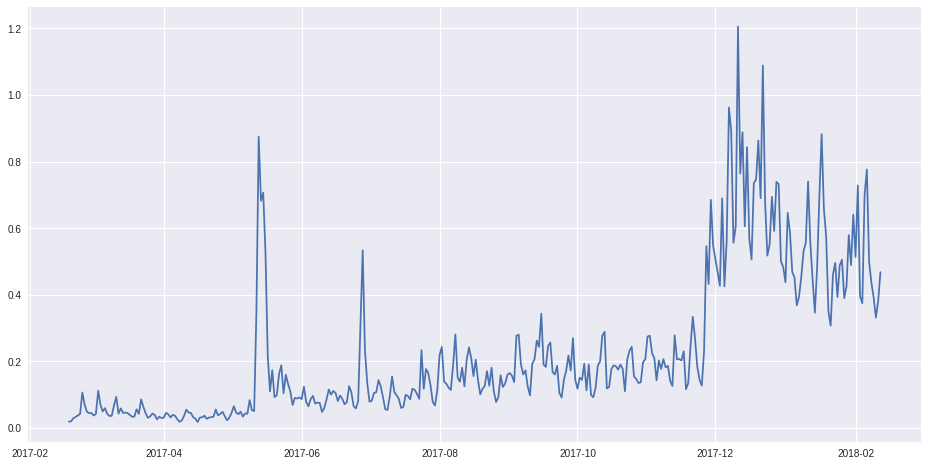

In [4]:
plt.plot(media.Value)

In [5]:
def calc_sma(prices, window=30):
    """Returns a Simple Moving Average"""
    return prices['close'].rolling(window=window).mean()

def calc_bollinger_bands(prices, window=30):
    """Returns DataFrame with basic indicators
    Standard Deviation, SMA, and the upper and lower Bollinger bands
    """
    prices['std'] = prices['close'].rolling(window=window).std()
    prices['sma'] = calc_sma(prices, window)
    prices['upper_band'] = prices['sma'] + 3 * prices['std']
    prices['lower_band'] = prices['sma'] - 3 * prices['std']
    prices['band_value'] = (prices['close'] - prices['sma']) / (2 * prices['std'])
    return prices

def calc_momentum(prices, window=1):
    """Indicates whether a stock price has been increasing or decreasing
    for the past x number of days
    """
    prices['momentum'] = (prices['close'] / prices['close'].shift(window) - 1)
    return prices.fillna(0)

def calc_rsi(prices, window=14):
    delta = prices['close'].diff()[1:]
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    roll_up = up.rolling(window=window).mean()
    roll_down = down.abs().rolling(window=window).mean()
    
    # Calculate the RSI based on SMA
    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))
    prices['rsi'] = rsi
    return prices

def calc_william_percent_r(prices, window=14):
    df = prices.copy()
    df['high'] = prices['close'].rolling(window=window).max()
    df['low'] = prices['close'].rolling(window=window).min()
    df['williams'] = (df['high'] - df['close']) / (df['high'] - df['low']) * -100
    prices['williams'] = df['williams']
    return prices

def calc_macd(prices):
    
    df = prices.copy()
    df['ema_12d'] = prices['close'].ewm(ignore_na=False,
                                         span=12,min_periods=0,
                                         adjust=True).mean()
    df['ema_26d'] = prices['close'].ewm(ignore_na=False,
                                         span=26,min_periods=0,
                                         adjust=True).mean()
    df['macd'] = df['ema_12d'] - df['ema_26d']
    df['macd_signal_line'] = df['macd'].rolling(window=9).mean()
    df['macd_historical'] = df['macd'] - df['macd_signal_line']

    prices['macd'] = df['macd_historical']
    return prices
    
def calc_stats(prices, days_out=5, dropna=False, add_params=True):
    prices = calc_bollinger_bands(prices, window=15)
    
    if add_params == True:
        prices = calc_momentum(prices)
        prices['sma_50d'] = calc_sma(prices, window=50)
        prices = calc_rsi(prices)
        prices = calc_william_percent_r(prices)
        prices = calc_macd(prices)

    prices['return'] =  prices['close'].shift(days_out * -1) / prices['close'] - 1
    prices['y'] = prices['return'] > 0
    prices['y'] = prices['y'].apply(lambda x : int(x))
    
    if dropna == True:
        prices = prices.dropna()
    
    prices = prices.drop('return', 1)
    
    return prices

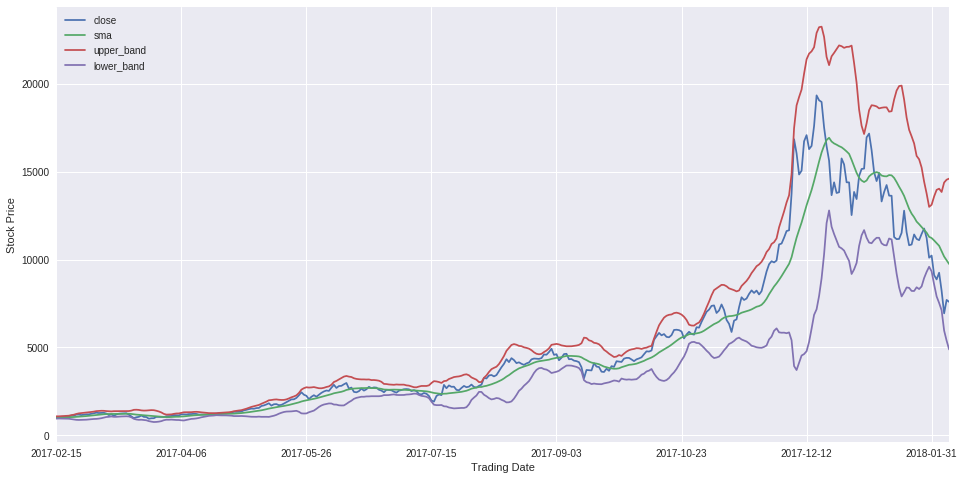

In [6]:
df2 = calc_stats(df, days_out=5, dropna=True, add_params=True)
ax = df2[['close', 'sma', 'upper_band', 'lower_band']].iloc[-len(media):, :].plot()
ax.set_ylabel('Stock Price')
ax.set_xlabel('Trading Date')

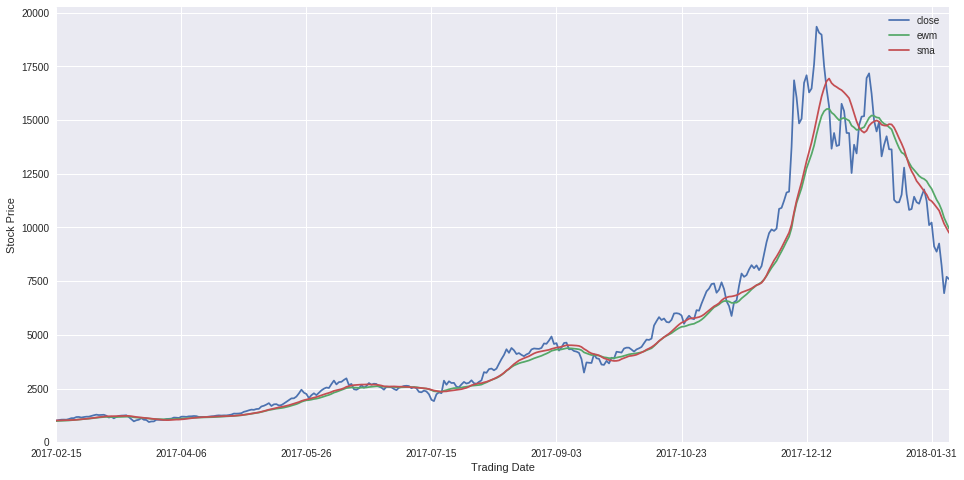

In [7]:
df2['ewm'] = df2['close'].ewm(span=20).mean()
df2['dif_moy_mob'] = df2['ewm']-df2['sma']
ax = df2[['close', 'ewm', 'sma']].iloc[-len(media):, :].plot()
ax.set_ylabel('Stock Price')
ax.set_xlabel('Trading Date')
plt.show()
df_lastyear = df2.join(media).dropna()

In [8]:
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier


clfs = {
'RF': RandomForestClassifier(n_estimators=50),
'KNN': KNeighborsClassifier(n_neighbors=10),
'NB':GaussianNB(),
'CART': tree.DecisionTreeClassifier(),
'DS': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm="SAMME",n_estimators=50),
'KNN': KNeighborsClassifier(n_neighbors=10),
'GB': GradientBoostingClassifier(n_estimators=50, learning_rate=0.01, max_depth=1, random_state=0),
'AB':AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)
}

In [9]:
import time
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def  run_classifier(clsf,X,Y,transformed_data='No'):
    """
    clsf: dicitionnary with different methods
    X: données caractéristiques
    Y: target
    transformed_data (optional): Add Normalization or PCA
    """
    
    if transformed_data == "Normalization":
        X=preprocessing.StandardScaler().fit_transform(X)
    if transformed_data == "PCA":
        X=preprocessing.StandardScaler().fit_transform(X)
        X=PCA(n_components=0.7).fit_transform(X)

    precision=[]
    method=[]
    kf = KFold(n_splits=10, shuffle=True, random_state=0)

    for i in clfs:

        print("Method {}: ".format(i))
        t0=time.time()
        cv_precision = cross_val_score(clfs[i], X, Y, cv=kf,scoring='precision')
        t1=time.time()
        print("Mean précision: {0:.5f}, Ecart-type précision: {1}, Time: {2:.3f}".format(np.mean(cv_precision),np.std(cv_precision),t1-t0))
        precision.append(np.mean(cv_precision))
        method.append(i)
        print("")
        
    return precision,method

In [17]:
df_1 = calc_stats(df, days_out=30, dropna=True, add_params=True)

df_1.drop(['time', 'timestamp','volumefrom', 'volumeto'], axis=1, inplace=True)

features = df_1[df_1.columns.difference(['y'])]
target =  df_1['y']
[precision,method]=run_classifier(clfs,features, target)

Method DS: 
Mean précision: 0.66578, Ecart-type précision: 0.03457428844052682, Time: 2.183

Method AB: 
Mean précision: 0.79435, Ecart-type précision: 0.02398607834925505, Time: 2.340

Method CART: 
Mean précision: 0.89863, Ecart-type précision: 0.02291845071727112, Time: 0.286

Method RF: 
Mean précision: 0.92788, Ecart-type précision: 0.016653662365647304, Time: 2.596

Method GB: 
Mean précision: 0.62254, Ecart-type précision: 0.026273506160476055, Time: 0.584

Method KNN: 
Mean précision: 0.86515, Ecart-type précision: 0.021037002449200936, Time: 0.068

Method NB: 
Mean précision: 0.62193, Ecart-type précision: 0.028241302845420542, Time: 0.036



In [31]:
from sklearn.metrics import confusion_matrix

random_forest = clfs["RF"]
random_forest.fit(features[:-200], target[:-200])
X = random_forest.predict(features[-200:]) 
confusion_matrix(X, target[-200:])

array([[ 59, 113],
       [  1,  27]])

In [29]:
features[:-200]

,band_value,close,high,low,lower_band,macd,momentum,open,rsi,sma,sma_50d,std,upper_band,williams
Date,,,,,,,,,,,,,,
2010-09-04,-0.431740,0.06238,0.06238,0.06120,0.058584,-0.000437,0.025144,0.06085,38.833333,0.063914,0.064282,0.001777,0.069244,-60.333333
2010-09-05,-0.576832,0.06160,0.06400,0.06050,0.058409,-0.000405,-0.012504,0.06238,38.030468,0.063594,0.064524,0.001728,0.068779,-68.000000
2010-09-06,-0.511312,0.06160,0.06270,0.06160,0.058312,-0.000353,0.000000,0.06160,40.427993,0.063301,0.064039,0.001663,0.068290,-68.000000
2010-09-07,-0.600417,0.06100,0.06201,0.06030,0.057944,-0.000329,-0.009740,0.06160,38.764045,0.063040,0.063643,0.001699,0.068136,-80.000000
2010-09-08,-0.258200,0.06200,0.06200,0.06099,0.057960,-0.000203,0.016393,0.06100,42.473118,0.062840,0.063388,0.001627,0.067720,-60.000000
2010-09-09,-0.467367,0.06111,0.06240,0.06109,0.057831,-0.000181,-0.014355,0.06200,42.268593,0.062594,0.063026,0.001588,0.067357,-77.800000
2010-09-10,-0.208869,0.06180,0.06180,0.06014,0.057798,-0.000098,0.011291,0.06111,41.294886,0.062447,0.063252,0.001550,0.067096,-63.782696
2010-09-11,0.456647,0.06366,0.06500,0.06190,0.058081,0.000113,0.030097,0.06180,48.862461,0.062358,0.063273,0.001426,0.066635,-26.358149
2010-09-12,-0.252646,0.06150,0.06210,0.06150,0.058120,0.000100,-0.033930,0.06366,44.158879,0.062185,0.063412,0.001355,0.066250,-69.818913


In [11]:
df42 = fetching.fetch.features_bitcoin()